In [1]:
# https://www.kaggle.com/artgor/santander-eda-fe-fs-and-models

In [2]:
# Libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
np.__version__

'1.16.1'

In [4]:
import datetime
import lightgbm as lgb
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import metrics
import json
import ast

In [5]:
from catboost import CatBoostClassifier
import time
from sklearn import linear_model
import eli5
from eli5.sklearn import PermutationImportance
import shap
from tqdm import tqdm_notebook

In [6]:

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [7]:
train = pd.read_csv('../data/train.csv.zip')
test = pd.read_csv('../data/test.csv.zip')
train.shape, test.shape

((200000, 202), (200000, 201))

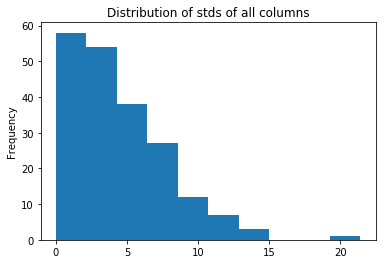

In [8]:
train[train.columns[2:]].std().plot('hist');
plt.title('Distribution of stds of all columns');

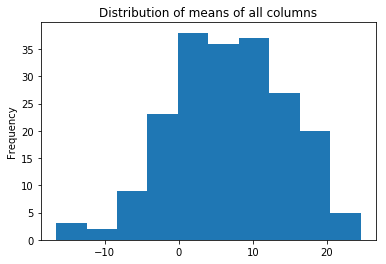

In [9]:
train[train.columns[2:]].mean().plot('hist');
plt.title('Distribution of means of all columns');

Distributions of first 28 columns


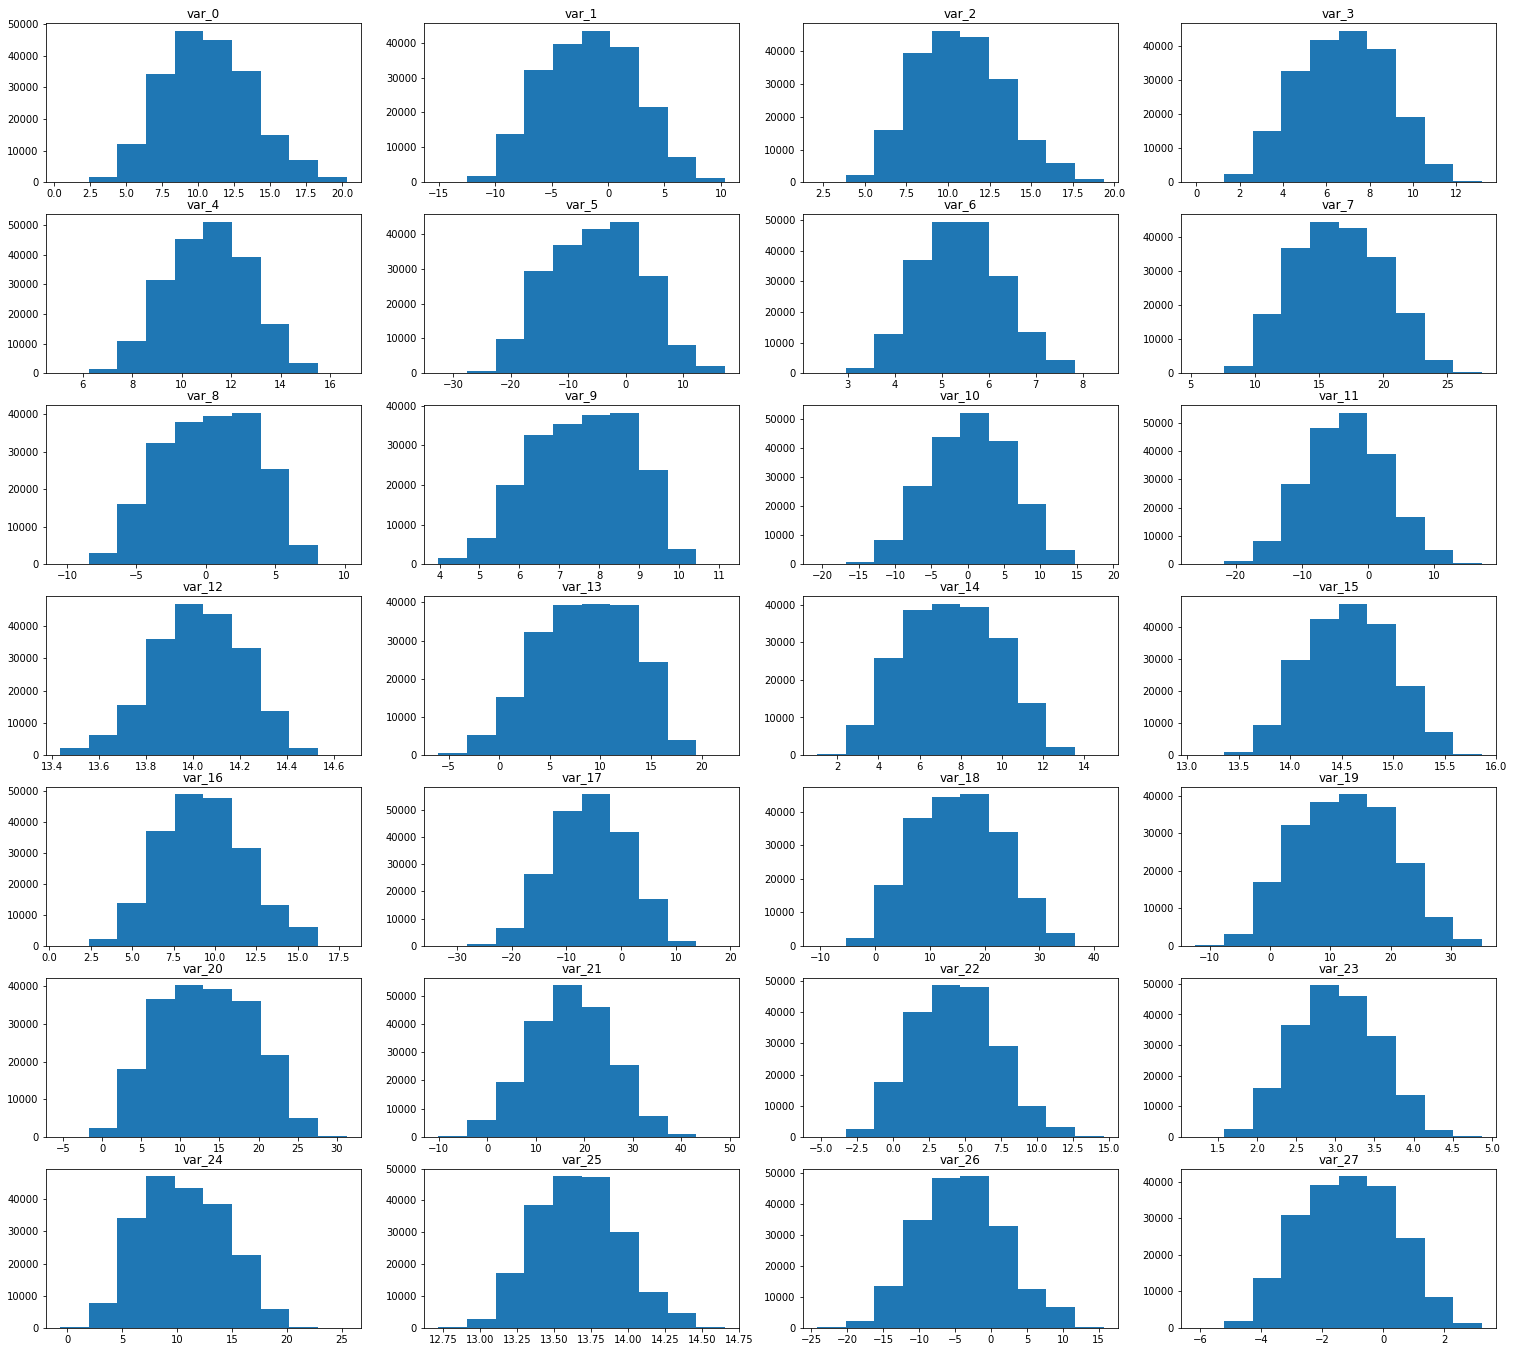

In [10]:
print('Distributions of first 28 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(list(train.columns)[2:30]):
    plt.subplot(7, 4, i + 1)
    plt.hist(train[col])
    plt.title(col)

Distributions of first 28 columns


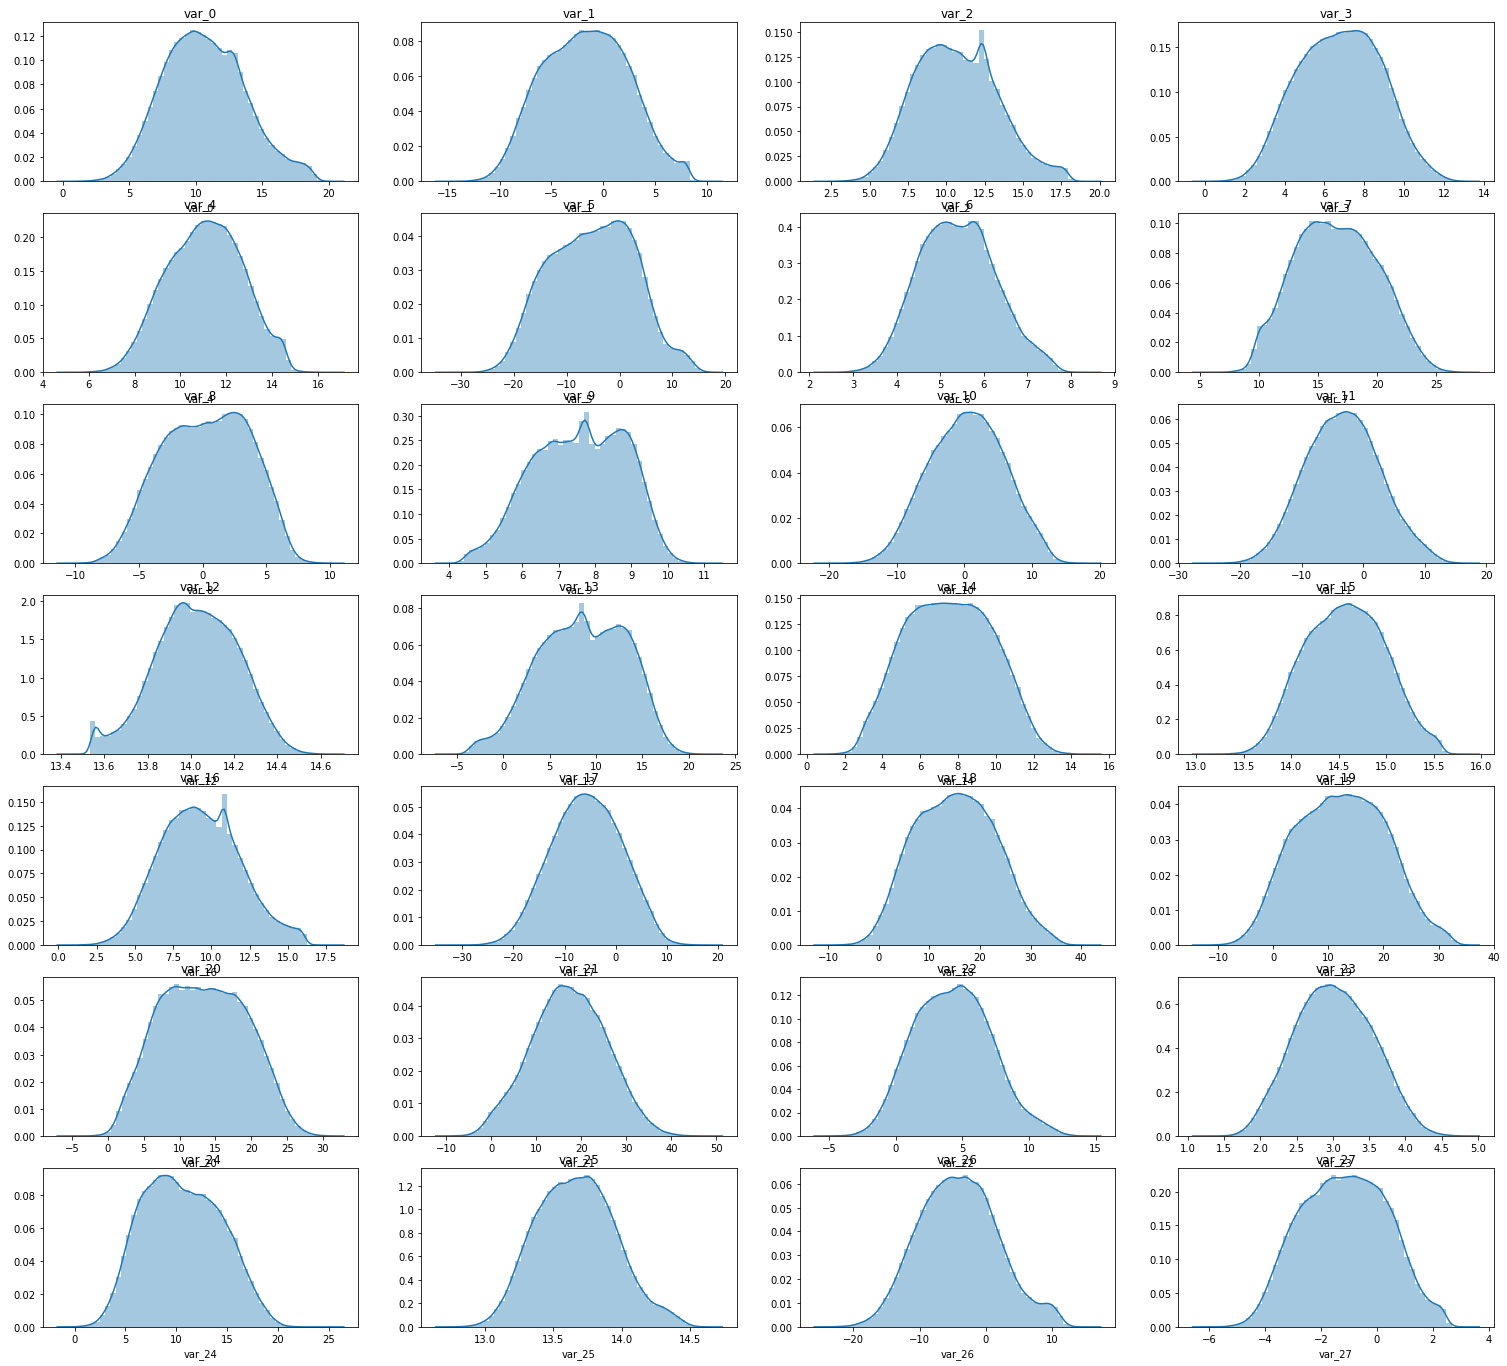

In [11]:
import seaborn as sns
print('Distributions of first 28 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(list(train.columns)[2:30]):
    plt.subplot(7, 4, i + 1)
    sns.distplot(train[col])
    plt.title(col)

In [12]:
train['target'].value_counts(normalize=True)

0    0.89951
1    0.10049
Name: target, dtype: float64

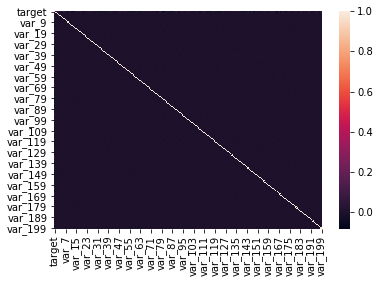

In [13]:
sns.heatmap(train.corr())

In [14]:
X = train.drop(['ID_code', 'target'], axis=1)
y = train['target']
X_test = test.drop(['ID_code'], axis=1)
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
repeated_folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=42)

In [15]:
from scipy.special import erfinv

class GaussRankScaler():

	def __init__( self ):
		self.epsilon = 0.001
		self.lower = -1 + self.epsilon
		self.upper =  1 - self.epsilon
		self.range = self.upper - self.lower

	def fit_transform( self, X ):
	
		i = np.argsort( X, axis = 0 )
		j = np.argsort( i, axis = 0 )

		assert ( j.min() == 0 ).all()
		assert ( j.max() == len( j ) - 1 ).all()
		
		j_range = len( j ) - 1
		self.divider = j_range / self.range
		
		transformed = j / self.divider
		transformed = transformed - self.upper
		transformed = erfinv( transformed )
		
		return transformed

In [16]:
from tqdm import tqdm_notebook
for col in tqdm_notebook(X.columns):
    X[col] = GaussRankScaler().fit_transform(X[col])
    X_test[col] = GaussRankScaler().fit_transform(X[col])

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

In [30]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

# model.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[roc_callback(training_data=(X_train, y_train),validation_data=(X_test, y_test))])

In [47]:
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization, Dropout

a = Input(shape=(200,))
x = Dense(200, activation='relu')(a)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=a, outputs=x)

In [48]:
from keras import optimizers

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=0.003)
rmsprop = optimizers.RMSprop(lr=0.01)
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['acc'])
batch_size=1024
epochs=40
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    validation_data=(X_val, y_val),
                    callbacks=[roc_callback(training_data=(X_train, y_train),validation_data=(X_val, y_val))])


Train on 160000 samples, validate on 40000 samples
Epoch 1/40
 - 4s - loss: 0.3506 - acc: 0.8624 - val_loss: 0.2605 - val_acc: 0.9053
roc-auc: 0.8248 - roc-auc_val: 0.8163                                                                                                    
Epoch 2/40
 - 3s - loss: 0.2558 - acc: 0.9077 - val_loss: 0.2456 - val_acc: 0.9100
roc-auc: 0.8523 - roc-auc_val: 0.8417                                                                                                    
Epoch 3/40
 - 3s - loss: 0.2435 - acc: 0.9113 - val_loss: 0.2407 - val_acc: 0.9118
roc-auc: 0.8623 - roc-auc_val: 0.8498                                                                                                    
Epoch 4/40
 - 3s - loss: 0.2373 - acc: 0.9131 - val_loss: 0.2383 - val_acc: 0.9130
roc-auc: 0.8676 - roc-auc_val: 0.8532                                                                                                    
Epoch 5/40
 - 3s - loss: 0.2339 - acc: 0.9144 - val_loss: 0.2366 

KeyboardInterrupt: 

In [ ]:
score = model.evaluate(X_val, y_val)
print(score)

In [17]:
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=20000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=1000,
                    early_stopping_rounds = 200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        if model_type == 'xgb':
#             print('1')
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_train.columns)
#             print('2')
            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
#             print('2a')
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
#             print('3')
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict_proba(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            # print(f'Fold {fold_n}. AUC: {score:.4f}.')
            # print('')
            
            y_pred = model.predict_proba(X_test)[:, 1]
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            y_pred = model_results.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000, learning_rate=0.05, loss_function='Logloss',  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test)[:, 1]
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))
        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores


Fold 0 started at Thu Feb 21 07:04:49 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.884941	valid_1's auc: 0.864219
[2000]	training's auc: 0.909669	valid_1's auc: 0.882933
[3000]	training's auc: 0.921215	valid_1's auc: 0.890625
[4000]	training's auc: 0.928136	valid_1's auc: 0.894629
[5000]	training's auc: 0.932974	valid_1's auc: 0.896815
[6000]	training's auc: 0.937096	valid_1's auc: 0.897746
[7000]	training's auc: 0.941006	valid_1's auc: 0.898207
Early stopping, best iteration is:
[7039]	training's auc: 0.941159	valid_1's auc: 0.898222
Fold 1 started at Thu Feb 21 07:10:44 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.884683	valid_1's auc: 0.864487
[2000]	training's auc: 0.909394	valid_1's auc: 0.883517
[3000]	training's auc: 0.921247	valid_1's auc: 0.891121
[4000]	training's auc: 0.928157	valid_1's auc: 0.895253
[5000]	training's auc: 0.932943	valid_1's auc: 0.897068
[6000]	training's auc: 0.

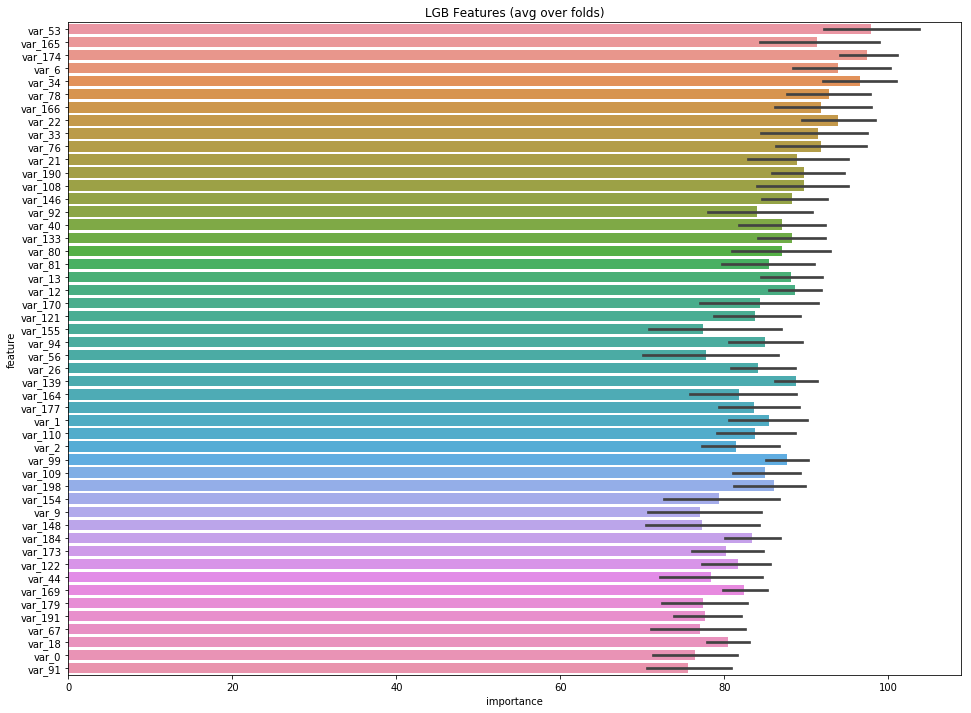

In [18]:
params = {'num_leaves': 8,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 16,
         'learning_rate': 0.0123,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'feature_fraction': 0.8201,
         'bagging_seed': 11,
         'reg_alpha': 1.728910519108444,
         'reg_lambda': 4.9847051755586085,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.01077313523861969,
         'min_child_weight': 19.428902804238373,
         'num_threads': 4}
oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [19]:
np.mean(scores)

importance    54.6504
fold           3.0000
dtype: float64

In [19]:
np.save('../cache/oof_lgb', oof_lgb)
np.save('../cache/prediction_lgb', prediction_lgb)
np.save('../cache/scores', scores)